In [211]:
import numpy as np
import astropy
from astropy.table import Table, join, vstack, hstack, Column
from astropy import stats as apstats
from tqdm import tqdm_notebook
import hastrofunc as hastro
from scipy import stats
from scipy.stats import norm
import imp
import glob
from datetime import datetime
import os

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
# sns.set_theme(style="ticks", color_codes=True)

In [212]:
runs = Table(names=["model","ion","E_ion","hvc_flag","RMS","R_squared",\
                    "vflat","vflat_err_lower","vflat_err_upper",\
                    "lag","lag_err_lower","lag_err_upper",\
                    "vz","vz_err_lower","vz_err_upper",\
                    "h0","h0_err_lower","h0_err_upper",\
                    "sigma","sigma_err_lower","sigma_err_upper",\
                    "R0","R0_err_lower","R0_err_upper",\
                    "hmin","hmin_err_lower","hmin_err_upper",\
                    "hmax","hmax_err_lower","hmax_err_upper"\
                   ],
            dtype=['<U40', '<U7', 'f', 'U','f','f',
                  'f','f','f',
                  'f','f','f',
                  'f','f','f',
                  'f','f','f',
                  'f','f','f',
                  'f','f','f',
                  'f','f','f',
                  'f','f','f'])


In [213]:
models = ['FlatSandwich','ThickSandwich','GaussianSandwich','RadialVerticalExponential','VerticalExponential']
ions =                ['CIV'  , 'SiIV'  , 'CII*'  , 'SiII'  , 'SII'  , 'FeII' , 'NiII'  , 'NV'   ]
ionization_energies = [64.4939, 45.14181, 24.38332, 16.34585, 23.3379, 16.1878, 18.16884, 97.8902]

# Make a dictionary so you can get ionization energies
E_ion = dict()
for i,ion in enumerate(ions):
    E_ion[ion] = ionization_energies[i]

hvc_flag = ['3']
lat_lim = 30

In [214]:
# Get the number of sightlines for each ion so goodness-of-fit can be normalized later
num_sightlines = []

ds = pd.read_table("data/sightlines_flag_"+hvc_flag[0]+".txt", sep=' ', skipinitialspace=True)
ds

for ion in ions:
    N = len(ds[(ds['ion'] == ion) & (np.abs(ds['Glat']) <= lat_lim)])
    print(N, ion, "sightlines to fit")
    num_sightlines.append(N)


num_sightlines

31 CIV sightlines to fit
28 SiIV sightlines to fit
28 CII* sightlines to fit
25 SiII sightlines to fit
28 SII sightlines to fit
18 FeII sightlines to fit
28 NiII sightlines to fit
23 NV sightlines to fit


[31, 28, 28, 25, 28, 18, 28, 23]

In [215]:
# Create a dictionary with ion info

ion_dict = dict()

for i, ion in enumerate(ions):
    ion_dict[ion] = {'ionization energy':ionization_energies[i],
                      'num_sightlines':num_sightlines[i]}
    
ion_dict

{'CIV': {'ionization energy': 64.4939, 'num_sightlines': 31},
 'SiIV': {'ionization energy': 45.14181, 'num_sightlines': 28},
 'CII*': {'ionization energy': 24.38332, 'num_sightlines': 28},
 'SiII': {'ionization energy': 16.34585, 'num_sightlines': 25},
 'SII': {'ionization energy': 23.3379, 'num_sightlines': 28},
 'FeII': {'ionization energy': 16.1878, 'num_sightlines': 18},
 'NiII': {'ionization energy': 18.16884, 'num_sightlines': 28},
 'NV': {'ionization energy': 97.8902, 'num_sightlines': 23}}

In [216]:
runs[runs["ion"] == 'SII']

model,ion,E_ion,hvc_flag,RMS,R_squared,vflat,vflat_err_lower,vflat_err_upper,lag,lag_err_lower,lag_err_upper,vz,vz_err_lower,vz_err_upper,h0,h0_err_lower,h0_err_upper,sigma,sigma_err_lower,sigma_err_upper,R0,R0_err_lower,R0_err_upper,hmin,hmin_err_lower,hmin_err_upper,hmax,hmax_err_lower,hmax_err_upper
str40,str7,float32,str1,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32


In [217]:
!pwd
os.getcwd()

/Users/hannahbish/Dropbox/QuaStar/DHmodels


'/Users/hannahbish/Dropbox/QuaStar/DHmodels'

In [218]:
test = Table.read(os.getcwd()+'/runs/hvc_flag_3/FlatSandwich/params_FlatSandwich_NV.txt',format='ascii')

In [219]:
test

col1,col2,col3,col4
str9,float64,float64,float64
vflat,217.047,-0.216,0.231
lag,10.016,-2.049,2.025
vz,-13.328,-0.142,0.143
h0,0.043,-0.007,0.007
R_squared,0.196,-999.0,-999.0
RMS,29.074,-999.0,-999.0


In [224]:
# Load model results, add a row to column for each

# filepath = os.getcwd()+'/runs/'
filepath = os.getcwd()+'/runs/lat_'+str(lat_lim)+'/'

for model in models:
    print(model)
#     if model == 'RadialVerticalExponential': break
    for ion in ions:
        print(ion)
        for hflag in hvc_flag:
            runs.add_row(vals=['-999']*len(runs.colnames))
            runs[-1]['model'],runs[-1]['ion'],runs[-1]['hvc_flag'],runs[-1]['E_ion'] = model, ion, hflag, E_ion[ion] # Add model, ion, and HVC flag of this run to the row of the table you just added
            temp = Table.read(filepath+'hvc_flag_'+hflag+'/'+model+'/params_'+model+'_'+ion+'.txt',format='ascii') # Read in output file
            for row in temp:
                param = row[0]
                runs[-1][param] = row[1] # parameter value
                if (param != 'RMS') & (param != 'R_squared'):
                    runs[-1][param+'_err_lower'] = str(row[2])[1:] # parameter lower error
                    runs[-1][param+'_err_upper'] = str(row[3])[1:] # parameter upper error
                
#                 print(row[0])
                

FlatSandwich
CIV
SiIV
CII*
SiII
SII
FeII
NiII
NV
ThickSandwich
CIV
SiIV
CII*
SiII
SII
FeII
NiII
NV
GaussianSandwich
CIV
SiIV
CII*
SiII
SII
FeII
NiII
NV
RadialVerticalExponential


In [225]:
# Add a column with normalized goodness-of-fit

NRMS = []

for row in runs:
    NRMS.append(row['RMS']/np.sqrt(ion_dict[row['ion']]['num_sightlines']))

runs['NRMS'] = NRMS

In [226]:
ion_dict['CIV']['num_sightlines']

31

In [227]:
# Set h_0 as the height of the middle of the slab for the ThickSandwich model
for row in runs:
    if row['model'] == 'ThickSandwich':
        row['h0'] = (row['hmin']+row['hmax'])/2
        print (row['h0'])


0.2595
0.465
0.307
0.41550002
0.431
0.37699997
0.16000001
0.241
0.2595
0.465
0.307
0.41550002
0.431
0.37699997
0.16000001
0.241
0.2595
0.465
0.307
0.41550002
0.431
0.37699997
0.16000001
0.241
0.2595
0.465
0.307
0.41550002
0.431
0.37699997
0.16000001
0.241


In [228]:

runs

model,ion,E_ion,hvc_flag,RMS,R_squared,vflat,vflat_err_lower,vflat_err_upper,lag,lag_err_lower,lag_err_upper,vz,vz_err_lower,vz_err_upper,h0,h0_err_lower,h0_err_upper,sigma,sigma_err_lower,sigma_err_upper,R0,R0_err_lower,R0_err_upper,hmin,hmin_err_lower,hmin_err_upper,hmax,hmax_err_lower,hmax_err_upper,NRMS
str40,str7,float32,str1,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64
FlatSandwich,CIV,64.4939,3,22.517,0.392,220.25,0.561,0.568,10.171,2.061,0.032,5.138,0.315,0.317,0.246,0.007,0.007,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,4.044172621364163
FlatSandwich,SiIV,45.14181,3,20.996,0.527,219.651,0.962,0.972,10.205,2.044,0.018,-5.662,0.328,0.335,0.454,0.007,0.007,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,3.9678710924400287
FlatSandwich,CII*,24.38332,3,20.861,0.212,232.128,0.654,0.662,10.092,2.039,0.991,-6.257,0.347,0.342,0.296,0.008,0.008,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,3.9423584472573046
FlatSandwich,SiII,16.34585,3,18.539,0.495,223.531,0.807,0.814,10.137,1.982,0.986,-9.605,0.342,0.339,0.373,0.009,0.008,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,3.7077999114990234
FlatSandwich,SII,23.3379,3,11.812,0.563,234.39,0.89,0.885,10.028,2.027,0.966,-1.618,0.341,0.338,0.423,0.007,0.007,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,2.2322582294980173
FlatSandwich,FeII,16.1878,3,44.267,0.083,233.408,0.856,0.869,10.121,2.021,0.001,10.397,0.45,0.463,0.379,0.009,0.008,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,10.43383155811682
FlatSandwich,NiII,18.16884,3,17.359,0.32,226.422,0.389,0.392,10.063,2.007,0.002,-17.148,0.362,0.355,0.142,0.008,0.008,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,3.2805425021852237
FlatSandwich,NV,97.8902,3,27.025,0.222,225.367,0.538,0.537,10.199,2.034,0.95,-11.898,0.352,0.358,0.231,0.008,0.007,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,5.635101960350509
ThickSandwich,CIV,64.4939,3,22.515,0.393,221.162,0.979,0.427,12.838,2.913,0.719,5.01,0.628,0.493,0.2595,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.124,0.046,0.117,0.395,0.093,0.054,4.043813265510461


In [229]:
print(runs[runs['model'] == 'FlatSandwich'])

   model     ion   E_ion   ... hmax_err_lower hmax_err_upper        NRMS       
------------ ---- -------- ... -------------- -------------- ------------------
FlatSandwich  CIV  64.4939 ...         -999.0         -999.0  4.044172621364163
FlatSandwich SiIV 45.14181 ...         -999.0         -999.0 3.9678710924400287
FlatSandwich CII* 24.38332 ...         -999.0         -999.0 3.9423584472573046
FlatSandwich SiII 16.34585 ...         -999.0         -999.0 3.7077999114990234
FlatSandwich  SII  23.3379 ...         -999.0         -999.0 2.2322582294980173
FlatSandwich FeII  16.1878 ...         -999.0         -999.0  10.43383155811682
FlatSandwich NiII 18.16884 ...         -999.0         -999.0 3.2805425021852237
FlatSandwich   NV  97.8902 ...         -999.0         -999.0  5.635101960350509
FlatSandwich  CIV  64.4939 ...         -999.0         -999.0  4.044172621364163
FlatSandwich SiIV 45.14181 ...         -999.0         -999.0 3.9678710924400287
         ...  ...      ... ...          

In [230]:
for ion in ions:
    best_R2 = max(runs['R_squared'][runs['ion'] == ion])
    best_RMS = min(runs['RMS'][runs['ion'] == ion])
    best_model = runs['model'][(runs['ion'] == ion) & (runs['RMS'] == best_RMS)]
    if len(best_model) > 1:
        print(ion,'\t',"Tie between:", [m for m in best_model])
    else:
        print(ion,'\t',runs['model'][(runs['ion'] == ion) & (runs['RMS'] == best_RMS)][0])
#     print(ion,"\t Max R^2 = ",best_R2,"\t Best model = ",best_model)

CIV 	 Tie between: ['RadialVerticalExponential', 'RadialVerticalExponential', 'RadialVerticalExponential']
SiIV 	 Tie between: ['FlatSandwich', 'ThickSandwich', 'FlatSandwich', 'ThickSandwich', 'FlatSandwich', 'ThickSandwich', 'FlatSandwich', 'ThickSandwich']
CII* 	 Tie between: ['GaussianSandwich', 'GaussianSandwich', 'GaussianSandwich', 'GaussianSandwich']
SiII 	 Tie between: ['GaussianSandwich', 'GaussianSandwich', 'GaussianSandwich', 'GaussianSandwich']
SII 	 Tie between: ['ThickSandwich', 'ThickSandwich', 'ThickSandwich', 'ThickSandwich']
FeII 	 Tie between: ['ThickSandwich', 'ThickSandwich', 'ThickSandwich', 'ThickSandwich']
NiII 	 Tie between: ['GaussianSandwich', 'GaussianSandwich', 'GaussianSandwich', 'GaussianSandwich']
NV 	 Tie between: ['ThickSandwich', 'ThickSandwich', 'ThickSandwich', 'ThickSandwich']


In [231]:
# runs['model'][(runs['ion'] == ion) & (runs['R_squared'] == best_R2)]
np.where(runs['R_squared'][runs['ion'] == ion] == max(runs['R_squared'][runs['ion'] == ion]))

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),)

In [232]:
runs['model'][runs['ion'] == 'CIV'], runs['R_squared'][runs['ion'] == 'CIV']

(<Column name='model' dtype='str40' length=15>
              FlatSandwich
             ThickSandwich
          GaussianSandwich
 RadialVerticalExponential
              FlatSandwich
             ThickSandwich
          GaussianSandwich
 RadialVerticalExponential
              FlatSandwich
             ThickSandwich
          GaussianSandwich
 RadialVerticalExponential
              FlatSandwich
             ThickSandwich
          GaussianSandwich, <Column name='R_squared' dtype='float32' length=15>
  0.392
  0.393
  0.392
 -999.0
  0.392
  0.393
  0.392
 -999.0
  0.392
  0.393
  0.392
 -999.0
  0.392
  0.393
  0.392)

In [233]:
table_param = 'RMS'

print('\t','FlatSand','\t\t','ThickSand','\t\t','GaussSand','\t\t','RadVertExp','\t','VertExp')
for ion in ions:
    print(ion+'\t', runs[(runs['ion'] == ion)][0][table_param],
          '\t\t',runs[(runs['ion'] == ion)][1][table_param],
          '\t\t',runs[(runs['ion'] == ion)][2][table_param],
          '\t\t',runs[(runs['ion'] == ion)][3][table_param],
          '\t\t',runs[(runs['ion'] == ion)][4][table_param])
    print()
#     for model in models:
#         print([row for row in runs[(runs['ion'] == ion) & (runs['model'] == model)]['R_squared']])

	 FlatSand 		 ThickSand 		 GaussSand 		 RadVertExp 	 VertExp
CIV	 22.517 		 22.515 		 22.52 		 -999.0 		 22.517

SiIV	 20.996 		 20.996 		 20.997 		 20.996 		 20.996

CII*	 20.861 		 20.842 		 20.829 		 20.861 		 20.842

SiII	 18.539 		 18.426 		 18.333 		 18.539 		 18.426

SII	 11.812 		 11.801 		 11.814 		 11.812 		 11.801

FeII	 44.267 		 44.246 		 44.264 		 44.267 		 44.246

NiII	 17.359 		 17.358 		 17.352 		 17.359 		 17.358

NV	 27.025 		 27.02 		 27.029 		 27.025 		 27.02



In [234]:
table_param = 'NRMS'

print('\t','FlatSand','\t\t','ThickSand','\t\t','GaussSand','\t\t','RadVertExp','\t','VertExp')
for ion in ions:
    print(ion+'\t', runs[(runs['ion'] == ion)][0][table_param],
          '\t\t',runs[(runs['ion'] == ion)][1][table_param],
          '\t\t',runs[(runs['ion'] == ion)][2][table_param],
          '\t\t',runs[(runs['ion'] == ion)][3][table_param],
          '\t\t',runs[(runs['ion'] == ion)][4][table_param])
    print()
#     for model in models:
#         print([row for row in runs[(runs['ion'] == ion) & (runs['model'] == model)]['R_squared']])

	 FlatSand 		 ThickSand 		 GaussSand 		 RadVertExp 	 VertExp
CIV	 4.044172621364163 		 4.043813265510461 		 4.0447114838597535 		 -179.42569672474815 		 4.044172621364163

SiIV	 3.9678710924400287 		 3.9678710924400287 		 3.9680599708654904 		 3.9678710924400287 		 3.9678710924400287

CII*	 3.9423584472573046 		 3.9387675944434717 		 3.9363110935474395 		 3.9423584472573046 		 3.9387675944434717

SiII	 3.7077999114990234 		 3.6852001190185546 		 3.6666000366210936 		 3.7077999114990234 		 3.6852001190185546

SII	 2.2322582294980173 		 2.2301793052254033 		 2.232636166576446 		 2.2322582294980173 		 2.2301793052254033

FeII	 10.43383155811682 		 10.4288818322277 		 10.433124839760989 		 10.43383155811682 		 10.4288818322277

NiII	 3.2805425021852237 		 3.280353623759762 		 3.2792196322969716 		 3.2805425021852237 		 3.280353623759762

NV	 5.635101960350509 		 5.634059563272484 		 5.635935957554866 		 5.635101960350509 		 5.634059563272484



In [235]:
# Make array for plotting with seaborn
pd_runs = runs.to_pandas()

[Text(0, 0, 'Flat\nSandwich'),
 Text(1, 0, 'Thick\nSandwich'),
 Text(2, 0, 'Gaussian\nSandwich'),
 Text(3, 0, 'Radial Vertical\nExponential')]

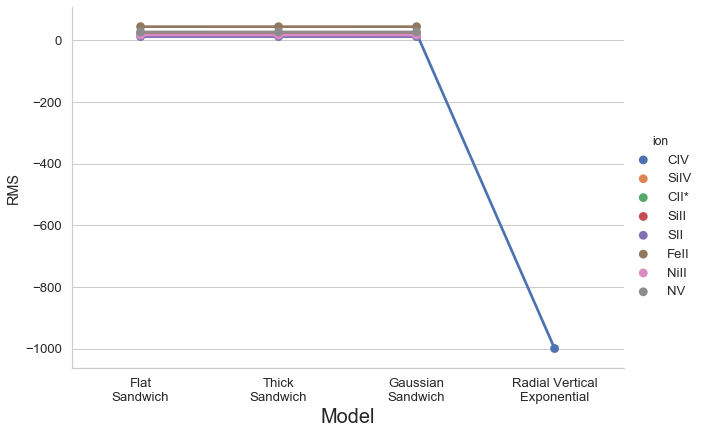

In [236]:
# cp.xlabel(fontsize=20)
# sns.set_style("white")
# sns.set(font_scale=1)
sns.set(style="whitegrid", font_scale=1.2)
# fig, ax = plt.subplots()

# sns.catplot(x="model", y="RMS", hue="ion",
#             palette={"male": "g", "female": "m"},
#             markers=["^", "o"], linestyles=["-", "--"],
#             kind="point", data=runs)

# plt.figure(figsize = (15,8))

cp = sns.catplot(x="model", y="RMS", hue="ion",
            kind="point", data=pd_runs,
            height=6,aspect=1.5)
# ax.set_xlabel('X_axis',fontsize=20);
cp.axes[0,0].set_xlabel('Model',fontsize=20)
cp.axes[0,0].set_xticklabels(['Flat\nSandwich','Thick\nSandwich','Gaussian\nSandwich','Radial Vertical\nExponential','Vertical\nExponential'])
# plt.set_xtickslabels()

In [247]:
df3 = pd_runs[['model','ion','RMS','NRMS','R_squared','vflat','lag','vz','h0']]#[pd_runs['model'] != 'RadialVerticalExponential']

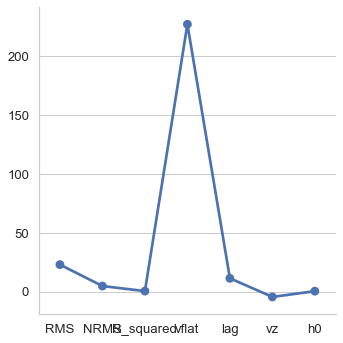

In [248]:
sns.catplot(data=df3, cat='ion',orient="v", kind="point")

In [249]:
pd_runs[['model','lag','lag_err_upper','lag_err_lower']]


,model,lag,lag_err_upper,lag_err_lower
0,FlatSandwich,10.171,0.032,2.061
1,FlatSandwich,10.205,0.018,2.044
2,FlatSandwich,10.092,0.991,2.039
3,FlatSandwich,10.137,0.986,1.982
4,FlatSandwich,10.028,0.966,2.027
...,...,...,...,...
94,GaussianSandwich,11.082,0.130,2.091
95,GaussianSandwich,10.568,0.650,2.249
96,GaussianSandwich,10.535,0.424,2.418
97,GaussianSandwich,10.258,0.292,2.125


ValueError: 'c' argument has 6 elements, which is not acceptable for use with 'x' with size 0, 'y' with size 0.

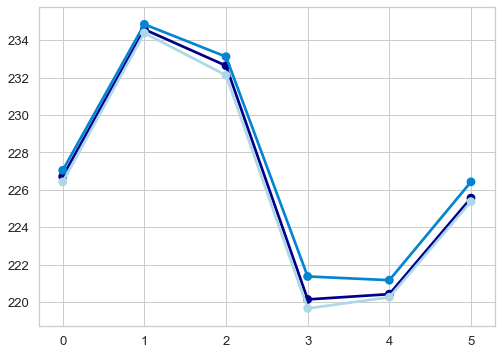

In [250]:
# sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'})
sns.set(style="whitegrid", font_scale=1.2)
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Helvetica'
matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'

rows, cols = 3,2
order = ['NV','CIV','SiIV','CII*','SII','NiII']
order = ['NiII','SII','CII*','SiIV','CIV','NV']
hue_order = ['GaussianSandwich','ThickSandwich','FlatSandwich','RadialVerticalExponential','VerticalExponential']
palette=["darkblue","xkcd:cerulean","lightblue",'xkcd:forest green',"xkcd:soft green"]

# hue_order = ['GaussianSandwich','ThickSandwich','FlatSandwich','VerticalExponential']
# palette=["darkblue","xkcd:cerulean","lightblue","xkcd:soft green"]

labelsize = 25

fig = plt.figure(figsize=(18,20))
plt.subplot(rows, cols, 1)
sns.pointplot(x="ion", y="vflat", hue="model", data=df3, order=order, height=2.5, hue_order=hue_order,palette=palette)
plt.legend([],[],frameon=False)
plt.ylim(210,240)
plt.ylabel(r'$\rm v_{flat}$ [km/s]',fontsize=labelsize)
plt.title(r'$\rm v_{flat}$',fontsize=labelsize)

# Add legend 
# fig.legend(loc='upper left', bbox_to_anchor=(0.47, 0.69), frameon=True, handletextpad=0.1, fontsize=20)

plt.subplot(rows, cols, 2)
sns.pointplot(x="ion", y="lag", hue="model", data=df3, order=order, height=2.5, hue_order=hue_order,palette=palette)
plt.legend(loc='lower left', frameon=True, handletextpad=0.1, fontsize=20)
plt.ylim(ymin=0)
plt.ylabel(r'$\rm lag$ [km/s/kpc]',fontsize=labelsize)
plt.title(r'$\rm lag$',fontsize=labelsize)

plt.subplot(rows, cols, 3)
sns.pointplot(x="ion", y="h0", hue="model", data=df3, order=order, height=2.5, hue_order=hue_order,palette=palette)
plt.legend([],[],frameon=False)
# plt.ylim(ymin=0)
plt.ylabel(r'$\rm h_{0}$ [kpc]',fontsize=labelsize)
plt.title(r'$\rm h_{0}$',fontsize=labelsize)

plt.subplot(rows, cols, 4)
sns.pointplot(x="ion", y="vz", hue="model", data=df3, order=order, height=2.5, hue_order=hue_order,palette=palette)
plt.legend([],[],frameon=False)
# plt.ylim(24,26)
plt.ylim(ymax=0, ymin=-18)
plt.ylabel(r'$\rm v_z$ [km/s]',fontsize=labelsize)
plt.title(r'$\rm v_z$',fontsize=labelsize)

plt.subplot(rows, cols, 5)
sns.pointplot(x="ion", y="NRMS", hue="model", data=df3, order=order, height=2.5, hue_order=hue_order,palette=palette)
plt.legend([],[],frameon=False)
# plt.ylim(24,26)
plt.ylim(ymin=0)
plt.ylabel(r'Normalized RMSE',fontsize=labelsize)
plt.title(r'Normalized RMSE',fontsize=labelsize)

plt.subplot(rows, cols, 6)
sns.pointplot(x="ion", y="R_squared", hue="model", data=df3, order=order, height=2.5, hue_order=hue_order,palette=palette)
plt.legend([],[],frameon=False)
# plt.ylim(24,26)
plt.ylim(ymin=0)
plt.ylabel(r'$\rm R^2$',fontsize=labelsize)
plt.title(r'$\rm R^2$',fontsize=labelsize)


# fig.set_xticklabels([])
for i, ax in enumerate(fig.axes):
    ax.set_xticklabels(order, fontsize=17)
    ax.tick_params(axis="y",labelsize=17)
    ax.set_xlabel('Ion\n (higher '+r'$\rm E_{i}\rightarrow$)', fontsize=20)

# plt.subplot(rows, cols, 4)
# sns.pointplot(x="ion", y="sigma", hue="model", data=df3, height=2.5)

plt.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.4)

plt.savefig('./model_comparison_lat<'+str(lat_lim)+'.png')

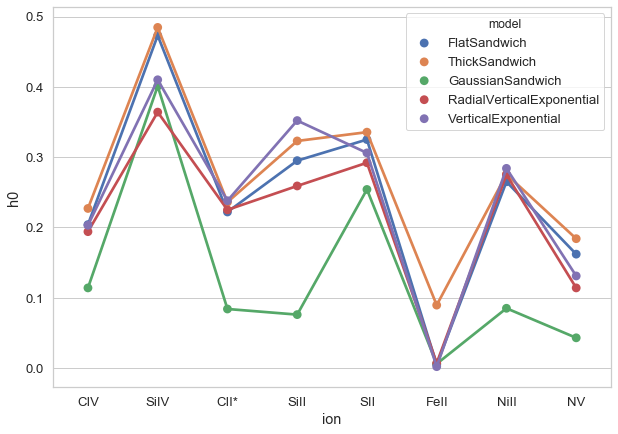

In [95]:
plt.figure(figsize=(10,7))
sns.pointplot(x="ion", y="h0", hue="model", data=df3, height=2.5)